### Instruction to run this notbook:
1- Requirment: matplotlib,pandas,torch,numpy,tqdm

2-change results_dir to where you want the .gif to be stored

3- Run first two cell, and change location of the main folder so we can import odeint.py

4-change the datasets path

5- Run same code for the three datasets

In [80]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/ProbAI/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/ProbAI


In [81]:
import pandas as pd
import matplotlib.pyplot as plt

import numpy as np
import torch
import torch.optim as optim
import torch.nn.functional as F
import torch.nn.init as init
from torch import nn
from torch import distributions
from torch.distributions import Uniform, TransformedDistribution, SigmoidTransform
from torch.nn.parameter import Parameter

In [82]:
data_moons = pd.read_csv('/content/drive/MyDrive/ProbAI/datasets/two_moons.csv')
two_blobs = pd.read_csv('/content/drive/MyDrive/ProbAI/datasets/two_blobs.csv')
boomerang = pd.read_csv('/content/drive/MyDrive/ProbAI/datasets/boomerang.csv')

#data_moons2.head()
data_moons=data_moons.to_numpy()
two_blobs=two_blobs.to_numpy()
boomerang=boomerang.to_numpy()
x=data_moons[:, :1]
y=data_moons[:,1:2]
new_x = np.reshape(x, (50, 10))
new_y = np.reshape(y, (50, 10))
xx=torch.from_numpy(new_x)
yy=torch.from_numpy(new_y)
#plt.scatter(*data_moons2.T, s=1, color='red')

data_moons_t=torch.from_numpy(data_moons)
two_blobs_t=torch.from_numpy(two_blobs)
boomerang_t=torch.from_numpy(boomerang)
#print(data_moons_t.shape)
#print(data_moons)

In [83]:
class MLP(nn.Module):
    """ a simple 4-layer MLP """

    def __init__(self, nin, nout, nh):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(nin, nh),
            nn.LeakyReLU(0.2),
            nn.Linear(nh, nh),
            nn.LeakyReLU(0.2),
            nn.Linear(nh, nh),
            nn.LeakyReLU(0.2),
            nn.Linear(nh, nout),
        )
    def forward(self, x):
        return self.net(x)

In [84]:
class AffineHalfFlow(nn.Module):
    """
    As seen in RealNVP, affine autoregressive flow (z = x * exp(s) + t), where half of the 
    dimensions in x are linearly scaled/transfromed as a function of the other half.
    Which half is which is determined by the parity bit.
    - RealNVP both scales and shifts (default)
    """
    def __init__(self, dim, parity, net_class=MLP, nh=24, scale=True, shift=True):
        super().__init__()
        self.dim = dim
        self.parity = parity
        self.s_cond = lambda x: x.new_zeros(x.size(0), self.dim // 2)
        self.t_cond = lambda x: x.new_zeros(x.size(0), self.dim // 2)
        if scale:
            self.s_cond = net_class(self.dim // 2, self.dim // 2, nh)
        if shift:
            self.t_cond = net_class(self.dim // 2, self.dim // 2, nh)
        
    def forward(self, x):
        x0, x1 = x[:,::2], x[:,1::2]
        if self.parity:
            x0, x1 = x1, x0
        s = self.s_cond(x0)
        t = self.t_cond(x0)
        z0 = x0 # untouched half
        z1 = torch.exp(s) * x1 + t # transform this half as a function of the other
        if self.parity:
            z0, z1 = z1, z0
        z = torch.cat([z0, z1], dim=1)
        log_det = torch.sum(s, dim=1)
        return z, log_det
    
    def backward(self, z):
        z0, z1 = z[:,::2], z[:,1::2]
        if self.parity:
            z0, z1 = z1, z0
        s = self.s_cond(z0)
        t = self.t_cond(z0)
        x0 = z0 # this was the same
        x1 = (z1 - t) * torch.exp(-s) # reverse the transform on this half
        if self.parity:
            x0, x1 = x1, x0
        x = torch.cat([x0, x1], dim=1)
        log_det = torch.sum(-s, dim=1)
        return x, log_det


In [85]:
class NormalizingFlow(nn.Module):
    """ A sequence of Normalizing Flows is a Normalizing Flow """

    def __init__(self, flows):
        super().__init__()
        self.flows = nn.ModuleList(flows)

    def forward(self, x):
        m, _ = x.shape
        log_det = torch.zeros(m)
        zs = [x]
        for flow in self.flows:
            x, ld = flow.forward(x)
            log_det += ld
            zs.append(x)
        return zs, log_det

    def backward(self, z):
        m, _ = z.shape
        log_det = torch.zeros(m)
        xs = [z]
        for flow in self.flows[::-1]:
            z, ld = flow.backward(z)
            log_det += ld
            xs.append(z)
        return xs, log_det


In [86]:
class NormalizingFlowModel(nn.Module):
    """ A Normalizing Flow Model is a (prior, flow) pair """
    
    def __init__(self, prior, flows):
        super().__init__()
        self.prior = prior
        self.flow = NormalizingFlow(flows)
    
    def forward(self, x):
        zs, log_det = self.flow.forward(x)
        prior_logprob = self.prior.log_prob(zs[-1]).view(x.size(0), -1).sum(1)
        return zs, prior_logprob, log_det

    def backward(self, z):
        xs, log_det = self.flow.backward(z)
        return xs, log_det
    
    def sample(self, num_samples):
        z = self.prior.sample((num_samples,))
        xs, _ = self.flow.backward(z)
        return xs

In [69]:
# construct a model
prior = TransformedDistribution(Uniform(torch.zeros(2), torch.ones(2)), SigmoidTransform().inv) # Logistic distribution

# RealNVP
flows = [AffineHalfFlow(dim=2, parity=i%2) for i in range(9)]


# construct the model
model = NormalizingFlowModel(prior, flows)

# optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5) # todo tune WD
model.train()
for k in range(1000):
    x = data_moons_t.float()

    zs, prior_logprob, log_det = model(x)
    logprob = prior_logprob + log_det
    loss = -torch.sum(logprob) # NLL

    model.zero_grad()
    loss.backward()
    optimizer.step()

    if k % 100 == 0:
        print(loss.item())

1484.56787109375
1000.51806640625
859.2213134765625
823.1942749023438
748.6896362304688
587.3509521484375
462.04888916015625
410.9945068359375
369.3813171386719
340.09326171875


(-6.772734355926514, 6.824917507171631, -5.494299149513244, 8.690459942817688)

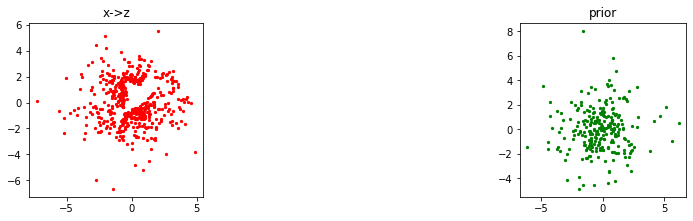

In [70]:
model.eval()

x = data_moons_t.float()
zs, prior_logprob, log_det = model(x)
z = zs[-1]

x = x.detach().numpy()
z = z.detach().numpy()
p = model.prior.sample([128, 2]).squeeze()


plt.figure(figsize=plt.figaspect(0.2))

plt.subplot(1, 2, 1)
#plt.xlim((-1.2, 1.2))
#plt.ylim((-1.5, 1.5))
plt.scatter(z[:,0], z[:,1], c='r', s=5)
plt.title('x->z')
plt.axis('scaled')

plt.subplot(1, 2, 2)
#plt.xlim((-10, 45))
#plt.ylim((-15, 15))
plt.scatter(p[:,0], p[:,1], c='g', s=5)
plt.title('prior')
plt.axis('scaled')







(-1.4235842943191528,
 3.038867783546448,
 -0.7462295860052108,
 2.2488789528608324)

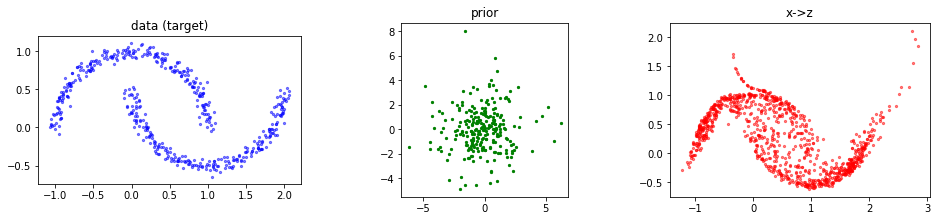

In [71]:
zs = model.sample(128*8)
z = zs[-1]
z = z.detach().numpy()


plt.figure(figsize=plt.figaspect(0.2))

plt.subplot(1, 3, 1)
#plt.xlim((-1.2, 1.2))
#plt.ylim((-1.5, 1.5))
plt.scatter(x[:,0], x[:,1], c='b', s=5, alpha=0.5)
plt.axis('scaled')
plt.title('data (target)')

plt.subplot(1, 3, 2)
#plt.xlim((-10, 45))
#plt.ylim((-15, 15))
plt.scatter(p[:,0], p[:,1], c='g', s=5)
plt.title('prior')
plt.axis('scaled')


plt.subplot(1, 3, 3)
plt.scatter(z[:,0], z[:,1], c='r', s=5, alpha=0.5)
plt.title('x->z')
plt.axis('scaled')


# Run same code for the second datasets ( boomerang)



3122.07275390625
2368.00634765625
2232.526611328125
2146.89404296875
2103.024169921875
2076.98876953125
2062.639892578125
2055.4501953125
2053.671142578125
2048.69873046875


(-6.784760463237763,
 68.46468757390976,
 -16.489306688308716,
 13.531461954116821)

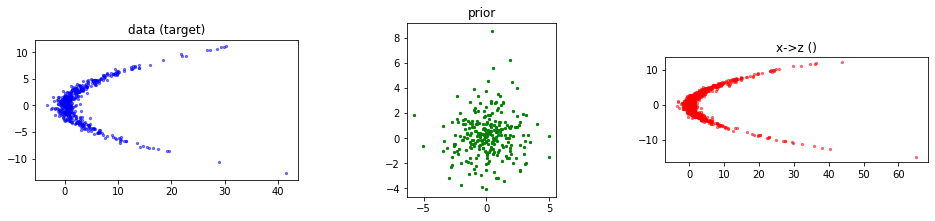

In [79]:
# construct a model
prior = TransformedDistribution(Uniform(torch.zeros(2), torch.ones(2)), SigmoidTransform().inv) # Logistic distribution

# RealNVP
flows = [AffineHalfFlow(dim=2, parity=i%2) for i in range(9)]


# construct the model
model = NormalizingFlowModel(prior, flows)

# optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5) # todo tune WD
model.train()
for k in range(1000):
    x =  boomerang_t.float()

    zs, prior_logprob, log_det = model(x)
    logprob = prior_logprob + log_det
    loss = -torch.sum(logprob) # NLL

    model.zero_grad()
    loss.backward()
    optimizer.step()

    if k % 100 == 0:
        print(loss.item())
model.eval()

x = boomerang_t.float()
zs, prior_logprob, log_det = model(x)
z = zs[-1]

x = x.detach().numpy()
z = z.detach().numpy()
p = model.prior.sample([128, 2]).squeeze()
zs = model.sample(128*8)
z = zs[-1]
z = z.detach().numpy()


plt.figure(figsize=plt.figaspect(0.2))

plt.subplot(1, 3, 1)
#plt.xlim((-1.2, 1.2))
#plt.ylim((-1.5, 1.5))
plt.scatter(x[:,0], x[:,1], c='b', s=5, alpha=0.5)
plt.axis('scaled')
plt.title('data (target)')

plt.subplot(1, 3, 2)
#plt.xlim((-10, 45))
#plt.ylim((-15, 15))
plt.scatter(p[:,0], p[:,1], c='g', s=5)
plt.title('prior')
plt.axis('scaled')


plt.subplot(1, 3, 3)
plt.scatter(z[:,0], z[:,1], c='r', s=5, alpha=0.5)
plt.title('x->z ()')
plt.axis('scaled')
 

# Run same code for the third datasets ( two_blobs)


1590.6834716796875
957.5841674804688
401.721435546875
290.56622314453125
225.13272094726562
179.29901123046875
156.93138122558594
144.09190368652344
135.70709228515625
129.0120086669922


(-1.1605840355157853,
 1.0613323479890824,
 -1.4702692687511445,
 2.9834100663661958)

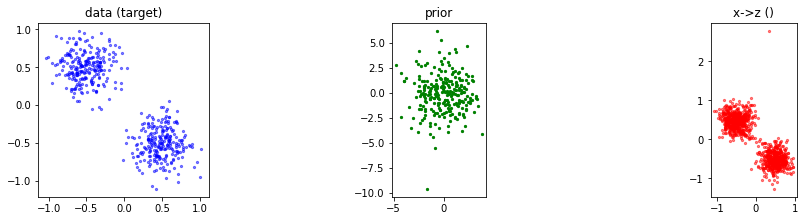

In [87]:
# construct a model
prior = TransformedDistribution(Uniform(torch.zeros(2), torch.ones(2)), SigmoidTransform().inv) # Logistic distribution

# RealNVP
flows = [AffineHalfFlow(dim=2, parity=i%2) for i in range(9)]


# construct the model
model = NormalizingFlowModel(prior, flows)

# optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5) # todo tune WD
model.train()
for k in range(1000):
    x =  two_blobs_t.float()

    zs, prior_logprob, log_det = model(x)
    logprob = prior_logprob + log_det
    loss = -torch.sum(logprob) # NLL

    model.zero_grad()
    loss.backward()
    optimizer.step()

    if k % 100 == 0:
        print(loss.item())
model.eval()

x =two_blobs_t.float()
zs, prior_logprob, log_det = model(x)
z = zs[-1]

x = x.detach().numpy()
z = z.detach().numpy()
p = model.prior.sample([128, 2]).squeeze()
zs = model.sample(128*8)
z = zs[-1]
z = z.detach().numpy()


plt.figure(figsize=plt.figaspect(0.2))

plt.subplot(1, 3, 1)
#plt.xlim((-1.2, 1.2))
#plt.ylim((-1.5, 1.5))
plt.scatter(x[:,0], x[:,1], c='b', s=5, alpha=0.5)
plt.axis('scaled')
plt.title('data (target)')

plt.subplot(1, 3, 2)
#plt.xlim((-10, 45))
#plt.ylim((-15, 15))
plt.scatter(p[:,0], p[:,1], c='g', s=5)
plt.title('prior')
plt.axis('scaled')


plt.subplot(1, 3, 3)
plt.scatter(z[:,0], z[:,1], c='r', s=5, alpha=0.5)
plt.title('x->z ()')
plt.axis('scaled')